<a href="https://colab.research.google.com/github/Shresth-Mehta/Neural_Networks_API/blob/master/Self_Implemented_Neural_Network_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install --upgrade wandb
!wandb login 3b198426fb8c2113ad027f82a1cc9366f0b81b99

Requirement already up-to-date: wandb in /usr/local/lib/python3.6/dist-packages (0.8.28)
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
Successfully logged in to Weights & Biases!


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
#import wandb
import os

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Saving the model

In [0]:
def save_model(filename,model_obj):
  mod=model_obj
  if(filename==None):
    filename=mod.model_run_name
  fileobj=open(filename,'wb')
  pickle.dump(mod,fileobj)
    
def restore_model(filename):                                                
  return pickle.load(open(filename,'rb'))

# **Model Class:**

In [0]:
class Model:
  def __init__(self,in_dim,out_dim,loss,optimizer,learning_rate,regularization,moment,plot_loss=True,use_wandb=False,save_best=False,use_acc=False):
    self.in_dim=in_dim
    self.layers=[]
    self.curr_dim=in_dim
    self.out_dim=out_dim
    self.optimizer=optimizer
    self.regularization=regularization
    self.loss_fn=loss()
    self.loss_name=self.loss_fn.name()
    self.learning_rate=learning_rate
    self.moment=moment
    self.plot_loss=plot_loss
    self.use_wandb=use_wandb
    self.save_best=save_best
    self.acc=use_acc
    self.model_run_name="no_name"

  def add_Dense(self,neuron_type,num_neurons):
    layer=neuron_type(self.curr_dim,num_neurons)
    self.layers.append(layer)
    self.curr_dim=num_neurons
      
  def predict(self,X):                                                          # X should be an n-d array with (len,1)
    y=X
    for layer in self.layers:
      y=layer.H_matrix(y)
    return y

  def __wandb_save(self,epoch,batch_size,learning_rate,momentum,loss):
    wandb.init(project="ell_409_assignment_1")
    layers_list=[]
    for layer in self.layers:
      layers_list.append(str(layer.neuron_type)+" "+str(layer.num_neurons))
    self.model_run_name=str(wandb.run.name)
    print(self.model_run_name)
    wandb.config.layers=layers_list
    wandb.config.epoch=epoch
    wandb.config.batch_size=batch_size
    wandb.config.learning_rate=learning_rate
    wandb.config.momentum=momentum
    wandb.config.loss_function=loss.name()
    wandb.config.accelerator=self.acc

  def fit(self,x_train,y_train,x_test,y_test,n_epoch,batch_size):                            # plot layers is a list of number of layers that you wanna plot 
    save_model("initialization",self)
    dataset=np.array(list(zip(x_train,y_train)))
    test_dataset=np.array(list(zip(x_test,y_test)))
    rec_against=[]
    train_error_mse_list=[]
    test_error_mse_list=[]
    train_error_ce_list=[]
    test_error_ce_list=[]
    if(self.use_wandb==True):
      self.__wandb_save(n_epoch,batch_size,self.learning_rate,self.moment,self.loss_fn)
    train_error_ce,train_error_mse,train_accuracy,unused=self.__get_logs(dataset)
    test_error_ce,test_error_mse,test_accuracy,num_teg=self.__get_logs(test_dataset)
    print("epoch:","0","train_error_ce:",train_error_ce,"train_error_mse:",train_error_mse,"train_accuracy:",train_accuracy,"num_eg:",unused)
    print("test_error_ce:",test_error_ce,"test_error_mse:",test_error_mse,"test_accuracy:",test_accuracy,"num_eg:",num_teg)
    min_testing_error=test_error_ce
    for epoch in range(n_epoch):
      num_eg=0
      batch_itr=1
      rec_against.append(epoch+1)
      for data_point,label in dataset:
        num_eg+=1
        data_point=data_point.reshape(len(data_point),1)
        label=label.reshape(len(label),1)                                       # data_point and label have to be numpy arrays (n,1)
        #pred=self.predict(data_point)
        if(batch_size==None):
          self.__back_propagate(data_point,label)
        else:
          if(self.acc==True and batch_itr==1):
            self.__accelerate()
          self.__batch_propagate(data_point,label)
          if(batch_itr==batch_size or num_eg==len(x_train)):
            self.__batch_update(batch_size)
            batch_itr=0
          batch_itr+=1
      np.random.shuffle(dataset)
      train_error_ce,train_error_mse,train_accuracy,unused=self.__get_logs(dataset)
      test_error_ce,test_error_mse,test_accuracy,num_teg=self.__get_logs(test_dataset)
      print("epoch:",epoch+1,"train_error_ce:",train_error_ce,"train_error_mse:",train_error_mse,"train_accuracy:",train_accuracy,"num_eg:",num_eg)
      print("test_error_ce:",test_error_ce,"test_error_mse:",test_error_mse,"test_accuracy:",test_accuracy,"num_eg:",num_teg) 
      if(self.use_wandb==True):
        wandb.log({"train_loss_mse":train_error_mse,"train_loss_ce":train_error_ce,"validation_loss_mse":test_error_mse,"validation_loss_ce":test_error_ce,"train_accuracy":train_accuracy,"validation_accuracy":test_accuracy})
      if(self.plot_loss==True):
        train_error_mse_list.append(train_error_mse)
        test_error_mse_list.append(test_error_mse)
        train_error_ce_list.append(train_error_ce)
        test_error_ce_list.append(test_error_ce)
      if(min_testing_error>=test_error_ce and test_accuracy>96.0 and self.save_best==True):
        min_testing_error=test_error_ce
        self.__save_model("best_model")

    if(self.plot_loss==True):
      plt.subplot(1,2,1)
      plt.plot(rec_against,train_error_mse_list,label="train_error_mse")
      plt.plot(rec_against,test_error_mse_list,label="test_error_mse")
      plt.legend()
      plt.subplot(1,2,2)
      plt.plot(rec_against,train_error_ce_list,label="train_error_ce")
      plt.plot(rec_against,test_error_ce_list,label="test_error_ce")
      plt.legend()
      plt.show()

  def __get_logs(self,dataset):
    c_e_loss=0
    m_s_e_loss=0
    correct=0
    loss_c_e=Cross_entropy_loss()
    loss_m_s_e=Squared_error_loss()
    for data_point,label in dataset:
      data_point=data_point.reshape(len(data_point),1)
      label=label.reshape(len(label),1)
      pred=self.predict(data_point)
      #sum_error+=self.loss_fn.expression(pred,label)
      c_e_loss+=loss_c_e.expression(pred,label)
      m_s_e_loss+=loss_m_s_e.expression(pred,label)
      if(np.argmax(pred)==np.argmax(label)):
        correct+=1
    #sum_error=sum_error/len(dataset)
    c_e_loss=c_e_loss/len(dataset)
    m_s_e_loss=m_s_e_loss/len(dataset)
    accuracy=correct*100.00/len(dataset) 
    return c_e_loss,m_s_e_loss,accuracy,len(dataset)

  def validate(self,x,y):
    dataset=np.array(list(zip(x,y)))
    ce_error,mse_error,acc,num=self.__get_logs(dataset)
    print("error_ce:",ce_error,"error_mse:",mse_error,"accuracy:",acc)


  def __accelerate(self):
    #print("acc_called")
    for layer in self.layers:
      layer.W=layer.W-self.moment*layer.M_W
      layer.B=layer.B-self.moment*layer.M_B

  def __back_propagate(self,x,y):
    if(self.acc==True):
      self.__accelerate()
    pred=self.predict(x)
    D_A=self.loss_fn.Der(self.layers[-1],y)
    for l_num in range(len(self.layers)-1,0,-1):
      D_W=np.matmul(D_A,self.layers[l_num-1].H.transpose())
      D_B=D_A
      D_H=np.matmul(self.layers[l_num].W.transpose(),D_A)
      D_A=(D_H*self.layers[l_num-1].Der_a())
      self.__update_weights(self.layers[l_num],D_W,D_B)  
    D_W=np.matmul(D_A,x.transpose())
    self.__update_weights(self.layers[0],D_W,D_A)
  
  def __batch_update(self,batch_size):
    for layer in self.layers:
      DW=layer.DW/batch_size
      DB=layer.DB/batch_size
      self.__update_weights(layer,DW,DB)
      layer.DW=np.zeros((layer.num_neurons,layer.in_dim))
      layer.DB=np.zeros((layer.num_neurons,1))

  def __batch_propagate(self,x,y):
    pred=self.predict(x)
    D_A=self.loss_fn.Der(self.layers[-1],y)
    for l_num in range(len(self.layers)-1,0,-1):
      D_W=np.matmul(D_A,self.layers[l_num-1].H.transpose())
      D_B=D_A
      self.layers[l_num].DW+=D_W
      self.layers[l_num].DB+=D_B
      D_H=np.matmul(self.layers[l_num].W.transpose(),D_A)
      D_A=(D_H*self.layers[l_num-1].Der_a()) 
    D_W=np.matmul(D_A,x.transpose())
    self.layers[0].DW+=D_W
    self.layers[0].DB+=D_A
  
  def __update_weights(self,layer,D_W,D_B):
    if(self.acc==True):
      layer.W=layer.W-self.learning_rate*D_W
      layer.B=layer.B-self.learning_rate*D_B
      layer.M_W=self.moment*layer.M_W+self.learning_rate*D_W
      layer.B_W=self.moment*layer.M_B+self.learning_rate*D_B   
    else:
      layer.M_W=self.learning_rate*D_W+self.moment*layer.M_W
      layer.M_B=self.learning_rate*D_B+self.moment*layer.M_B
      layer.W=layer.W-layer.M_W
      layer.B=layer.B-layer.M_B
      
  
  def __save_model(self,filename):
    mod=self
    fileobj=open(filename,'wb')
    pickle.dump(mod,fileobj)
  
  def save_in_wandb(self):
    self.__save_model(os.path.join(wandb.run.dir,"model"))

  def confusion_matrix(self,X,Y):
    y_pred=[]
    y_true=[]
    dataset=np.array(list(zip(X,Y)))
    for data_point,label in dataset:
      data_point=data_point.reshape(len(data_point),1)
      label=label.reshape(len(label),1)
      pred=self.predict(data_point)
      y_pred.append(np.argmax(pred))
      y_true.append(np.argmax(label))
    matrix=np.zeros((self.out_dim,self.out_dim))
    for i in range(len(y_true)):
      matrix[y_true[i]][y_pred[i]] +=1
    return (matrix,y_pred,y_true)
  

# Layers

In [0]:
class DenseLayer:
  def __init__(self,in_dim,num_neurons):
    self.W=np.random.randn(num_neurons,in_dim)*np.sqrt(2/(num_neurons+in_dim))
    self.B=np.zeros((num_neurons,1))                                            # Bias is not uniform for a layer
    self.num_neurons=num_neurons
    self.in_dim=in_dim
    self.A=np.zeros((num_neurons,1))
    self.H=np.zeros((num_neurons,1))
    self.rec_weights=[np.sum(np.absolute(self.W))/np.size(self.W)]
    self.neuron_type=None
    self.DW=np.zeros((num_neurons,in_dim))
    self.DB=np.zeros((num_neurons,1))
    self.M_W=np.zeros((num_neurons,in_dim))
    self.M_B=np.zeros((num_neurons,1))

  def update_weights_rec(self):
    self.rec_weights.append(np.sum(np.absolute(self.W))/np.size(self.W))

  def A_matrix(self,X):
    self.A=np.matmul(self.W,X)
    return

In [0]:
class Sigmoid_Layer(DenseLayer):
  def __init__(self,in_dim,num_neurons):
    DenseLayer.__init__(self,in_dim,num_neurons)
    self.neuron_type="sigmoid"
  def h(self,x):
    return 1.0/(1.0+np.exp(0-x))
  def Der_a(self):
    return self.H*(1-self.H)
  def H_matrix(self,X):
    self.A_matrix(X)
    self.H=self.h(self.A+self.B)
    return self.H
    

In [0]:
class Softmax_Layer(DenseLayer):
  def __init__(self,in_dim,num_neurons):
    DenseLayer.__init__(self,in_dim,num_neurons)
    self.neuron_type="softmax"
  def h(self,x):
    e=np.exp(x)
    ans=np.sum(e)
    return np.divide(e,ans)
  def Der_a(self):
    return self.H*(1-self.H)                                                                     # write the derivative(not needed)
  def H_matrix(self,X):
    self.A_matrix(X)
    self.H=self.h(self.A+self.B)
    return self.H

# Loss Functions

In [0]:
class Cross_entropy_loss:
  def name(self):
    return "Cross_entropy_loss"
  def expression(self,y_hat,y):
    return 0-np.log(y_hat[np.argmax(y)])
  def Der(self,layer,y):
    if(layer.neuron_type=="softmax"):
      return layer.H-y
    elif(layer.neuron_type=="sigmoid"):
      return (layer.H-1)*y                                                                   # complete the return statement
  

In [0]:
class Squared_error_loss:
  def name(self):
    return "Squared_error_loss"
  def expression(self,y_hat,y):
    return np.sum((y-y_hat)**2)/(2*len(y))
  def Der(self,layer,y):
    if(layer.neuron_type=="softmax"):
      return -(y-layer.H)*layer.H*(1-layer.H)/len(y)
    elif(layer.neuron_type=="sigmoid"):
      return -(y-layer.H)*layer.H*(1-layer.H)/len(y)
                                                                   

# Getting Mnist data

In [0]:
mnist_dataframe=pd.read_csv("https://download.mlcc.google.com/mledu-datasets/mnist_train_small.csv",
sep=",",header=None)
mnist_dataframe=mnist_dataframe.reindex(np.random.permutation(mnist_dataframe.index))
y=np.array(mnist_dataframe[0])
l=len(y)
y_labels=np.zeros((l,10))
for i,j in zip(y_labels,y):
  i[j]=1
mnist_dataframe=mnist_dataframe.drop(columns=[0])
x=mnist_dataframe.to_numpy()
x=x/255.0
print(x.shape,y_labels.shape)

(20000, 784) (20000, 10)


In [0]:
def test_train_split(frac,x,y):
  num_train=int((1-frac)*len(x))
  x_train=x[:num_train][:]
  y_train=y[:num_train][:]
  x_test=x[num_train:][:]
  y_test=y[num_train:][:]
  return (x_train,y_train,x_test,y_test)

In [0]:
x_train,y_train,x_test,y_test=test_train_split(0.05,x,y_labels)
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(19000, 784) (19000, 10) (1000, 784) (1000, 10)


In [0]:
val_x,val_y,non1,non2=test_train_split(0,x,y_labels)
print(val_x.shape,val_y.shape,non1.shape,non2.shape)

(20000, 784) (20000, 10) (0, 784) (0, 10)


# Getting Smaller dataset

In [0]:
def get_data(path):
  mnist_dataframe=pd.read_csv(path,
  sep=",",header=None)
  mnist_dataframe=mnist_dataframe.reindex(np.random.permutation(mnist_dataframe.index))
  y=np.array(mnist_dataframe[25])
  l=len(y)
  y_labels=np.zeros((l,10))
  for i,j in zip(y_labels,y):
    i[j]=1
  mnist_dataframe=mnist_dataframe.drop(columns=[25])
  x=mnist_dataframe.to_numpy()
  #x=x/255.0
  print(x.shape,y_labels.shape)
  return x,y_labels

def test_train_split(frac,x,y):
  num_train=int((1-frac)*len(x))
  x_train=x[:num_train][:]
  y_train=y[:num_train][:]
  x_test=x[num_train:][:]
  y_test=y[num_train:][:]
  return (x_train,y_train,x_test,y_test)

In [0]:
x,y=get_data("/content/drive/My Drive/trainData.csv")
x_train,y_train,x_test,y_test=test_train_split(0,x,y)
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(3000, 25) (3000, 10)
(3000, 25) (3000, 10) (0, 25) (0, 10)


# Getting The Prediction

In [0]:
def get_test_data(path):
  mnist_dataframe=pd.read_csv(path,
  sep=",",header=None)
  x=mnist_dataframe.to_numpy()
  #x=x/255.0
  print(x.shape)
  return x

def get_predictions(dataset,model_obj):
  predictions=[]
  id=[]
  i=1
  for data_point in dataset:
    data_point=data_point.reshape(len(data_point),1)                                     # data_point and label have to be numpy arrays (n,1)
    pred=model_obj.predict(data_point)
    predictions.append(np.argmax(pred))
    id.append(i)
    i+=1
  submission=pd.DataFrame()
  submission['id']=id
  submission['label']=predictions
  return submission

def get_submission_csv(test_data_path,model_obj,pred_csv_file_path):
  test_data=get_test_data(test_data_path)
  submission=get_predictions(test_data,model_obj)
  submission.to_csv(pred_csv_file_path,index=False)
  print(submission.head(10))

# Training the model

In [0]:
nn_1=Model(25,10,Cross_entropy_loss,None,0.01,None,0.01,True,False,True,False)   #moment,plot,wandb,save_best,accelerator                                                # 10-15-10 gave nan on weights of layer 2 and 3
nn_1.add_Dense(Sigmoid_Layer,80)
nn_1.add_Dense(Sigmoid_Layer,60)
nn_1.add_Dense(Softmax_Layer,10)

In [0]:
nn_1.learning_rate=0.1

epoch: 0 train_error_ce: [1.20932357] train_error_mse: 0.02825950296120366 train_accuracy: 70.2 num_eg: 3000
test_error_ce: [1.20932357] test_error_mse: 0.02825950296120366 test_accuracy: 70.2 num_eg: 3000
epoch: 1 train_error_ce: [1.1846922] train_error_mse: 0.028192603743833904 train_accuracy: 54.7 num_eg: 3000
test_error_ce: [1.1846922] test_error_mse: 0.028192603743833953 test_accuracy: 54.7 num_eg: 3000
epoch: 2 train_error_ce: [1.00854944] train_error_mse: 0.024221373507230377 train_accuracy: 63.9 num_eg: 3000
test_error_ce: [1.00854944] test_error_mse: 0.024221373507230463 test_accuracy: 63.9 num_eg: 3000
epoch: 3 train_error_ce: [0.7496409] train_error_mse: 0.017708300986113038 train_accuracy: 75.2 num_eg: 3000
test_error_ce: [0.7496409] test_error_mse: 0.017708300986113094 test_accuracy: 75.2 num_eg: 3000
epoch: 4 train_error_ce: [0.70088833] train_error_mse: 0.016429431327596455 train_accuracy: 76.16666666666667 num_eg: 3000
test_error_ce: [0.70088833] test_error_mse: 0.01642

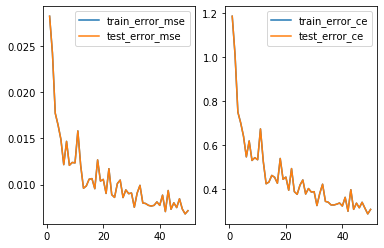

In [0]:
nn_1.fit(x_train,y_train,x_train,y_train,50,4)

In [0]:
get_submission_csv("/content/drive/My Drive/testData.csv",nn_1,"submission.csv")

(3000, 25)
   id  label
0   1      7
1   2      9
2   3      1
3   4      4
4   5      7
5   6      4
6   7      0
7   8      1
8   9      8
9  10      0


# Multiple Neural Networks: 1 vs rest and boosting algorithms

In [0]:
def predict_multiple(n_list,x,y,path="nan",pred_on_xy=False):
  if(pred_on_xy==True):  
    data=np.array(list(zip(x,y)))
    correct=0
    for data_point,label in data :
      out=[0]*10
      data_point=data_point.reshape(len(data_point),1)
      label=label.reshape(len(label),1)   
      for n_i in n_list:
        out[np.argmax(n_i.predict(data_point))]+=1
      pred_out=np.argmax(out)
      if(pred_out==np.argmax(label)):
        correct+=1
    accuracy=correct*100/len(x)
    print("accuracy:",accuracy)
  if(path!="nan"):
    data=get_test_data(path)
    predictions=[]
    id=[]
    i=1
    for data_point in data:
      out=[0]*10
      data_point=data_point.reshape(len(data_point),1)
      for n_i in n_list:
        out[np.argmax(n_i.predict(datapoint))]+=1
      predictions.append(np.argmax(out))
      id.append(i)
      i+=1  
      submission=pd.DataFrame()
    submission['id']=id
    submission['label']=predictions
    submission.to_csv(pred_csv_file_path,index=False)
    print(submission.head(10))    

In [0]:
nn=[nn_1,nn_2,nn_3,nn_4]

In [0]:
predict_multiple(nn,val_x,val_y,"nan",True)

accuracy: 95.08
